# Curso: Bioestatística — DIC (Delineamento Inteiramente Casualizado)
### Autores: Sandro da Silva Camargo e Fernando Cardoso

Dependências: pandas, numpy, scipy, statsmodels, matplotlib

Abra este código no seu google colab clicando [aqui](http://colab.research.google.com/github/Sandrocamargo/biostatistics/blob/master/python/bioe_03_dic.ipynb).

In [1]:
# Carregando bibliotecas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.multitest import multipletests

## Leitura e Preparação dos dados

Esta fase envolve:


*   Carregar a base de dados para uma variável
*   Definir os nomes das colunas, se necessário
*   Definir as colunas tratamento e repetição como categóricas
*   A base de dados deve ter 3 colunas: Tratamento, Repetição e Y (Variável Resposta)



In [2]:
!mkdir images
data = pd.read_csv("https://raw.githubusercontent.com/Sandrocamargo/biostatistics/refs/heads/master/datasets/dic-dados.txt", sep="\t", decimal=",", header=0)

# Renomear colunas 1 e 2 para Treatment e Repeat
data = data.rename(columns={data.columns[0]: "Treatment", data.columns[1]: "Repeat"})

# Recodificar tratamentos
map_trt = {"A": "CTRL", "B": "T1X", "C": "T2X"}
data["Treatment"] = data["Treatment"].replace(map_trt)

# Garantir tipos categóricos
data["Repeat"] = data["Repeat"].astype("category")
data["Treatment"] = data["Treatment"].astype("category")

# Mostra estrutura dos dados carregados
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Treatment  27 non-null     category
 1   Repeat     27 non-null     category
 2   Y          27 non-null     float64 
dtypes: category(2), float64(1)
memory usage: 914.0 bytes
None


In [3]:
# =========================
# ANOVA (one-way)
# =========================

model = smf.ols("Y ~ C(Treatment)", data=data).fit()
print(model.summary())
anova_table = anova_lm(model, typ=2)
print("\nANOVA (Type II):\n", anova_table)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     37.78
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           3.85e-08
Time:                        23:28:51   Log-Likelihood:                -8.3519
No. Observations:                  27   AIC:                             22.70
Df Residuals:                      24   BIC:                             26.59
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.4800    

Interpretação:
1. Qualidade geral do modelo
*   $R^2$ = 0,759, ou seja, 75,9% da variação da variável dependente (Y) é explicada pelos tratamentos.
*   $R^2$ ajustado = 0,739, ou seja, mesmo considerando o número de preditores, o modelo mantém boa qualidade de ajuste.
*   F-statistic = 37,78, p < 0,0001, ou seja, o modelo como um todo é estatisticamente significativo, ou seja, pelo menos um dos grupos de tratamento tem média significativamente diferente dos demais.

2. ANOVA
*   A soma de quadrados para o fator C(Treatment) é muito maior que a dos resíduos, mostrando forte efeito dos tratamentos.
*   p < 0,0001, ou seja, rejeitamos $H_0$ de igualdade das médias → há diferença significativa entre os grupos de tratamento.


3. Coeficientes
*   O Intercept representa a média do grupo de referência (CTRL): ≈ 2,48.
*   O grupo T1X tem média 0,96 unidades maior que o grupo de referência (diferença estatisticamente significativa).
*   O grupo T2X tem média 1,35 unidades maior que o grupo de referência (também altamente significativo).
*   Ambos os intervalos de confiança não incluem zero → reforça que os efeitos são positivos e reais.

**Podemos concluir que os dois tratamentos testados aumentaram significativamente a variável resposta em relação ao controle, sendo T2X o mais eficaz.**

Se o objetivo for reportar para um artigo, você pode escrever algo como:
*"A ANOVA indicou efeito significativo do fator Tratamento sobre Y (F(2,24)=37,78, p$<$0,0001). Comparado ao grupo controle, T1X apresentou aumento médio de 0,96 (IC 95%: 0,62-1,30; p$<$0,001) e T2X aumento médio de 1,35 (IC 95%: 1,02-1,69; p$<$0,001), indicando maior efeito de T2X."*

In [12]:
# =========================
# Totais por tratamento
# =========================

gb = data.groupby("Treatment", observed=False)["Y"]
Length = gb.size()
Mean = gb.mean()
Sum = gb.sum()

# Soma dos quadrados "crus" por tratamento (equivalente a rMR::sumsq)
Sum_Squares = gb.apply(lambda x: np.sum(np.square(x)))
totais = pd.DataFrame({"Length": Length, "Sum": Sum, "Sum_Squares": Sum_Squares, "Mean": Mean})
print("\nTotais por tratamento:\n", totais)


Totais por tratamento:
            Length   Sum  Sum_Squares      Mean
Treatment                                     
CTRL           10  24.8        62.04  2.480000
T1X             8  27.5        96.09  3.437500
T2X             9  34.5       133.09  3.833333


Interpretação Estatística:
*   Grupo Controle (CTRL) tem média 2,48 - serve como referência.
*   T1X tem média 3,44, cerca de +0,96 maior que CTRL.
*   T2X tem média 3,83, cerca de +1,35 maior que CTRL.

Esses valores são coerentes com o resultado anterior da regressão/ANOVA, que mostrou diferenças significativas para ambos os tratamentos em relação ao grupo controle.

Análise de Tendência
*   Existe uma tendência crescente de CTRL → T1X → T2X, sugerindo que os tratamentos têm efeito positivo incremental.
*   O ganho de T2X sobre T1X é de aproximadamente 0,39 (3,83 - 3,44). Para confirmar se essa diferença é estatisticamente significativa, seria necessário um pós-teste de comparações múltiplas (ex.: Tukey HSD).

Conclusão
*   CTRL apresenta o menor valor médio, como esperado.
*   T1X e T2X aumentam significativamente o valor de Y.
*   Há evidência de que T2X é mais eficaz que T1X, mas é preciso teste estatístico para confirmar se a diferença entre os dois é estatisticamente relevante.

In [13]:
# =========================
# t-tests dois a dois (Welch)
# =========================

def ttest_2grupos(df, g1, g2):
    y1 = df.loc[df["Treatment"] == g1, "Y"].values
    y2 = df.loc[df["Treatment"] == g2, "Y"].values
    res = stats.ttest_ind(y1, y2, equal_var=False)
    return {
        "Comparação": f"{g1} vs {g2}",
        "t": res.statistic,
        "p-valor": res.pvalue,
        "n1": len(y1),
        "n2": len(y2),
        "Média 1": y1.mean(),
        "Média 2": y2.mean(),
        "Significância": "✅ p<0.05" if res.pvalue < 0.05 else "❌ ns"
    }

resultados = [ttest_2grupos(data, g1, g2) for g1, g2 in [("CTRL","T1X"), ("CTRL","T2X"), ("T1X","T2X")]]
df_resultados = pd.DataFrame(resultados)

print("\n📊 Testes t de Welch - Comparações Par a Par")
print(df_resultados.to_string(index=False, float_format="%.4f"))


📊 Testes t de Welch - Comparações Par a Par
 Comparação        t  p-valor  n1  n2  Média 1  Média 2 Significância
CTRL vs T1X  -5.2089   0.0004  10   8   2.4800   3.4375      ✅ p<0.05
CTRL vs T2X -10.1947   0.0000  10   9   2.4800   3.8333      ✅ p<0.05
 T1X vs T2X  -1.9916   0.0692   8   9   3.4375   3.8333          ❌ ns


Análise crítica:
*   As duas comparações com CTRL são altamente significativas (p < 0.001), confirmando que ambos os tratamentos aumentaram de forma clara a variável resposta em relação ao controle.
*   T2X apresenta um efeito maior que T1X (t mais negativo, diferença média maior), mas a comparação direta entre eles não atinge significância a 5%, embora esteja perto do limiar (p ≈ 0.07).
*   Isso pode indicar que:
*   - O efeito de T2X realmente é maior que o de T1X, mas é preciso mais poder estatístico (amostra maior) para confirmar.
*   - Ou que a diferença entre os tratamentos é pequena e não clinicamente relevante.

Conclusão: Os resultados sugerem:
*   Efeito positivo significativo dos tratamentos T1X e T2X em relação ao controle.
*   Possível diferença entre T1X e T2X, mas não estatisticamente confirmada com o tamanho de amostra atual (8 e 9 observações, respectivamente).

Próximo passo: Se a diferença entre T1X e T2X for de interesse, considere:
*   Aumentar o tamanho da amostra para ganhar poder estatístico.
*   Calcular intervalos de confiança das médias para melhor visualizar a sobreposição.


Tukey HSD:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  CTRL    T1X   0.9575    0.0  0.5433 1.3717   True
  CTRL    T2X   1.3533    0.0  0.9521 1.7546   True
   T1X    T2X   0.3958 0.0707 -0.0285 0.8202  False
---------------------------------------------------


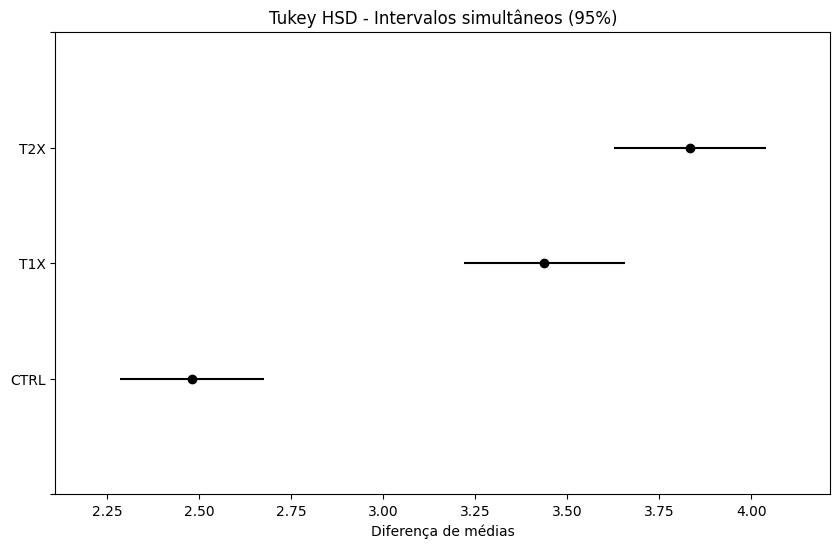

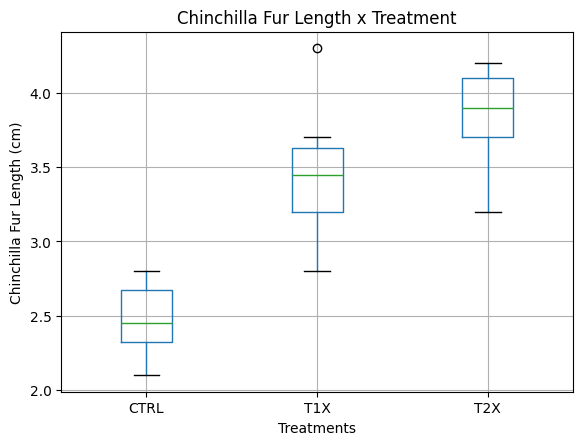

In [6]:
# =========================
# Tukey HSD
# =========================
mc = MultiComparison(data["Y"], data["Treatment"])
tukey = mc.tukeyhsd(alpha=0.05)
print("\nTukey HSD:\n", tukey.summary())

# Gráfico do Tukey (simultaneous CIs)
fig = tukey.plot_simultaneous()
plt.title("Tukey HSD - Intervalos simultâneos (95%)")
plt.xlabel("Diferença de médias")
plt.savefig("images/dic-tukey.png", dpi=150, bbox_inches="tight")
plt.show()

# Boxplot Y ~ Treatment
ax = data.boxplot(column="Y", by="Treatment")
plt.title("Chinchilla Fur Length x Treatment")
plt.suptitle("")
plt.xlabel("Treatments")
plt.ylabel("Chinchilla Fur Length (cm)")
plt.savefig("images/dic-tratamentos.png", dpi=150, bbox_inches="tight")
plt.show()


Shapiro-Wilk: W=0.9641, p-value=0.4565


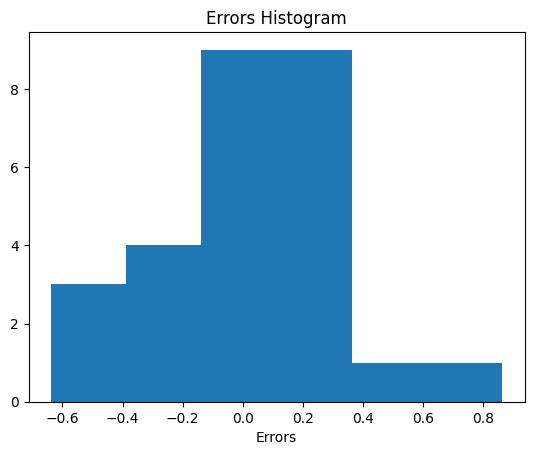


Bartlett: K^2=3.3116, p-value=0.1909


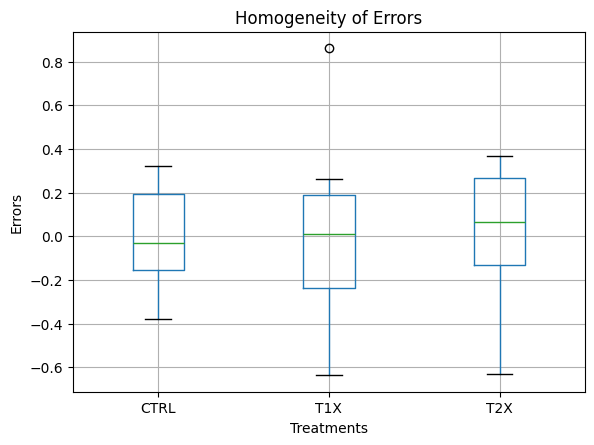


Levene (center=mean): stat=0.9638, p=0.3957
Levene (center=median): stat=0.9052, p=0.4178

Durbin-Watson dos resíduos: 2.4470


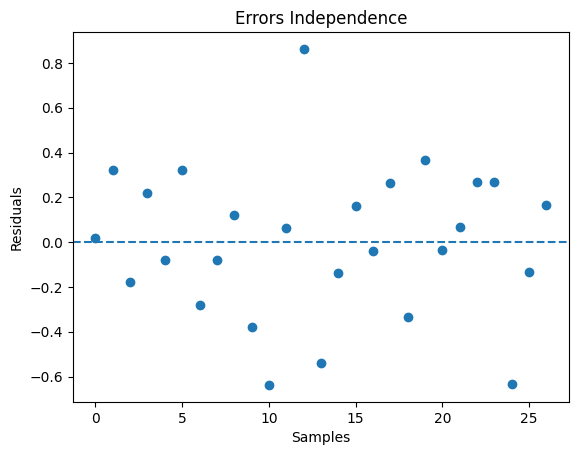

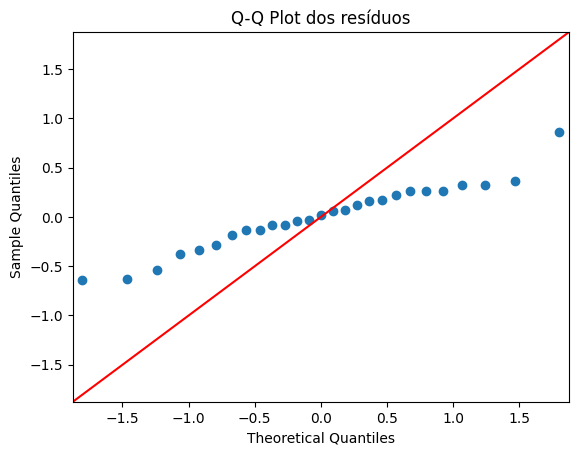

In [7]:
# =========================
# Pressupostos da ANOVA
# =========================
resid = model.resid

# Shapiro-Wilk para normalidade dos resíduos
shapiro_stat, shapiro_p = stats.shapiro(resid)
print(f"\nShapiro-Wilk: W={shapiro_stat:.4f}, p-value={shapiro_p:.4g}")

# Histograma dos resíduos
plt.hist(resid, bins="auto")
plt.title("Errors Histogram")
plt.xlabel("Errors")
plt.savefig("images/dic-errorshistogram.png", dpi=150, bbox_inches="tight")
plt.show()

# Bartlett (homogeneidade de variâncias)
groups = [data.loc[data["Treatment"] == g, "Y"].values for g in data["Treatment"].cat.categories]
bart_stat, bart_p = stats.bartlett(*groups)
print(f"\nBartlett: K^2={bart_stat:.4f}, p-value={bart_p:.4g}")

# Boxplot dos resíduos por tratamento
res_df = pd.DataFrame({"Residuals": resid, "Treatment": data["Treatment"].values})
ax = res_df.boxplot(column="Residuals", by="Treatment")
plt.title("Homogeneity of Errors")
plt.suptitle("")
plt.xlabel("Treatments"); plt.ylabel("Errors")
plt.savefig("images/dic-homogeneityErrors.png", dpi=150, bbox_inches="tight")
plt.show()

# Levene (média e mediana como centros)
lev_mean = stats.levene(*groups, center="mean")
lev_median = stats.levene(*groups, center="median")
print(f"\nLevene (center=mean): stat={lev_mean.statistic:.4f}, p={lev_mean.pvalue:.4g}")
print(f"Levene (center=median): stat={lev_median.statistic:.4f}, p={lev_median.pvalue:.4g}")

# Independência (Durbin-Watson)
dw = durbin_watson(resid)
print(f"\nDurbin-Watson dos resíduos: {dw:.4f}")

# Dispersão dos resíduos em ordem amostral
plt.plot(resid, "o")
plt.axhline(0, linestyle="--")
plt.title("Errors Independence")
plt.xlabel("Samples"); plt.ylabel("Residuals")
plt.savefig("images/dic-errorsindependence.png", dpi=150, bbox_inches="tight")
plt.show()

# QQ-plot (ajuste do modelo)
sm.qqplot(resid, line="45")
plt.title("Q-Q Plot dos resíduos")
plt.savefig("images/dic-qqplot.png", dpi=150, bbox_inches="tight")
plt.show()

In [8]:
# =========================
# Contrastes lineares (F-test)
# Equivalente aos contrastes do gmodels:
#   1) " CTRL vs (T1X + T2X) " = [2, -1, -1]
#   2) " T1X vs T2X "         = [0,  1, -1]
# Usamos um modelo sem intercepto para que os coeficientes = médias por tratamento.
# =========================
model_means = smf.ols("Y ~ 0 + C(Treatment)", data=data).fit()
print("\nModelo de médias (sem intercepto):\n", model_means.summary())

L = np.array([
    [ 2, -1, -1],  # CTRL vs (T1X + T2X)
    [ 0,  1, -1],  # T1X vs T2X
], dtype=float)

# As colunas de L devem seguir a ordem das categorias em model_means.params
# Obter a ordem correta dos coeficientes:
coef_names = list(model_means.params.index)  # ex.: ['C(Treatment)[CTRL]','C(Treatment)[T1X]','C(Treatment)[T2X]']
# Mapear para ordem CTRL, T1X, T2X
order = []
for label in ["CTRL", "T1X", "T2X"]:
    name = [c for c in coef_names if c.endswith(f"[{label}]")][0]
    order.append(coef_names.index(name))
P = np.eye(len(coef_names))[:, order]  # permutação para alinhar colunas

L_aligned = L @ P.T

# F-test conjunto (duas hipóteses ao mesmo tempo)
f_res = model_means.f_test(L_aligned)
print("\nContrastes (F-test conjunto):")
print(f_res)

# Testes individuais (t/F por contraste)
labels = [" CTRL vs (T1X + T2X) ", " T1X vs T2X "]
for i, lab in enumerate(labels):
    print(f"\nContraste: {lab}")
    print(model_means.t_test(L_aligned[i, :]))


Modelo de médias (sem intercepto):
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     37.78
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           3.85e-08
Time:                        23:28:57   Log-Likelihood:                -8.3519
No. Observations:                  27   AIC:                             22.70
Df Residuals:                      24   BIC:                             26.59
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [9]:
# =========================
# Modelo de regressão linear com fator (igual ao lm do R)
# =========================
model_lm = smf.ols("Y ~ C(Treatment)", data=data).fit()
print("\nANOVA do modelo lm:\n", anova_lm(model_lm, typ=2))
print("\nResumo do modelo lm:\n", model_lm.summary())


ANOVA do modelo lm:
                 sum_sq    df          F        PR(>F)
C(Treatment)  9.239324   2.0  37.778989  3.851430e-08
Residual      2.934750  24.0        NaN           NaN

Resumo do modelo lm:
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     37.78
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           3.85e-08
Time:                        23:28:57   Log-Likelihood:                -8.3519
No. Observations:                  27   AIC:                             22.70
Df Residuals:                      24   BIC:                             26.59
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
   

In [10]:
# =========================
# Comparações múltiplas adicionais
# - Bonferroni (equivalente a LSD.test com p.adjust='bonferroni')
# - Dunnett (CTRL vs outros): não há função nativa pronta no statsmodels; abaixo
#   fazemos testes CTRL vs cada grupo com ajuste de p (Holm), que é mais potente que Bonferroni.
# =========================
# Pairwise t-tests com ajuste Bonferroni
pairs = [("CTRL","T1X"), ("CTRL","T2X"), ("T1X","T2X")]
pvals = []
tvals = []
for g1, g2 in pairs:
    y1 = data.loc[data["Treatment"] == g1, "Y"].values
    y2 = data.loc[data["Treatment"] == g2, "Y"].values
    t_stat, p_raw = stats.ttest_ind(y1, y2, equal_var=False)
    tvals.append(t_stat); pvals.append(p_raw)

rej, p_adj, _, _ = multipletests(pvals, alpha=0.05, method="bonferroni")
bonf_results = pd.DataFrame({
    "pair": [f"{a} vs {b}" for a,b in pairs],
    "t": tvals,
    "p_raw": pvals,
    "p_bonferroni": p_adj,
    "reject_H0_0.05": rej
})
print("\nPairwise t-tests com ajuste Bonferroni:\n", bonf_results)

# "Dunnett-like": CTRL vs demais com ajuste Holm (mais potente que Bonferroni).
ctrl = "CTRL"
compares = [g for g in data["Treatment"].cat.categories if g != ctrl]
pvals_d = []
tvals_d = []
labels_d = []
for g in compares:
    y1 = data.loc[data["Treatment"] == ctrl, "Y"].values
    y2 = data.loc[data["Treatment"] == g, "Y"].values
    t_stat, p_raw = stats.ttest_ind(y1, y2, equal_var=False)
    pvals_d.append(p_raw); tvals_d.append(t_stat); labels_d.append(f"{ctrl} vs {g}")

rej_holm, p_holm, _, _ = multipletests(pvals_d, alpha=0.05, method="holm")
dunnett_like = pd.DataFrame({
    "comparação": labels_d,
    "t": tvals_d,
    "p_raw": pvals_d,
    "p_Holm": p_holm,
    "reject_H0_0.05": rej_holm
})
print("\nComparações 'Dunnett-like' (CTRL vs outros; ajuste Holm):\n", dunnett_like)


Pairwise t-tests com ajuste Bonferroni:
           pair          t         p_raw  p_bonferroni  reject_H0_0.05
0  CTRL vs T1X  -5.208855  4.012311e-04  1.203693e-03            True
1  CTRL vs T2X -10.194700  4.340407e-08  1.302122e-07            True
2   T1X vs T2X  -1.991616  6.924648e-02  2.077394e-01           False

Comparações 'Dunnett-like' (CTRL vs outros; ajuste Holm):
     comparação          t         p_raw        p_Holm  reject_H0_0.05
0  CTRL vs T1X  -5.208855  4.012311e-04  4.012311e-04            True
1  CTRL vs T2X -10.194700  4.340407e-08  8.680813e-08            True



Agrupamento por letras (Tukey):
   Treatment Group
0      CTRL     A
1       T1X     B
2       T2X     B


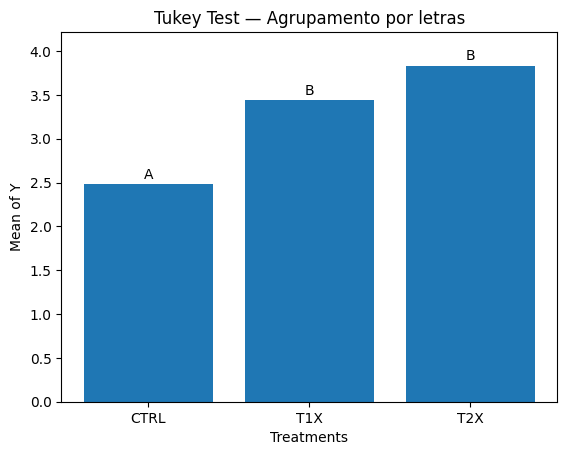

In [11]:
# =========================
# Agrupamento por letras (similar ao bar.group do agricolae a partir de Tukey)
# =========================
def cld_from_tukey(tukey_res):
    """
    Gera agrupamento por letras (Compact Letter Display) a partir do resultado do Tukey.
    Estratégia gulosa simples: garante que grupos que NÃO diferem compartilhem alguma letra.
    """
    groups = sorted(set(tukey_res.groupsunique))
    # matriz de diferenças significativas
    sig = { (min(a,b), max(a,b)): rej for a,b,meandiff,p,low,high,rej in tukey_res._results_table.data[1:] }

    letters = {g: "" for g in groups}
    current_letter = "A"
    remaining = set(groups)

    while remaining:
        g = sorted(remaining)[0]
        # todos que não diferem de g ainda não rotulados para esta letra
        same = [g]
        for h in sorted(remaining - {g}):
            key = (min(g,h), max(g,h))
            if not sig.get(key, False):  # False => não rejeita H0 => sem diferença
                # checar se h é diferente de algum já em 'same'
                ok = True
                for s in same:
                    k2 = (min(h,s), max(h,s))
                    if sig.get(k2, False):  # diferença significativa entre h e s
                        ok = False; break
                if ok:
                    same.append(h)
        # atribuir letra atual a todos em 'same'
        for s in same:
            letters[s] += current_letter
        remaining -= set(same)
        # próxima letra
        current_letter = chr(ord(current_letter) + 1)

    return pd.DataFrame({"Treatment": list(letters.keys()), "Group": list(letters.values())}).sort_values("Treatment")

cld = cld_from_tukey(tukey)
print("\nAgrupamento por letras (Tukey):\n", cld)

# (Opcional) Barras com letras
means = gb.mean().reset_index()
merged = means.merge(cld, on="Treatment")
plt.bar(merged["Treatment"], merged["Y"])
for i, (x, y, lab) in enumerate(zip(merged["Treatment"], merged["Y"], merged["Group"])):
    plt.text(i, y * 1.01, lab, ha="center", va="bottom")
plt.ylim(0, merged["Y"].max()*1.1)
plt.title("Tukey Test — Agrupamento por letras")
plt.xlabel("Treatments"); plt.ylabel("Mean of Y")
plt.savefig("images/dic-tukeytestgroups.png", dpi=150, bbox_inches="tight")
plt.show()

# =========================
# Observações sobre testes não implementados
# =========================
# - Duncan, SNK, Scheffé e Scott-Knott não estão implementados em statsmodels.
#   Em Python, a prática usual é usar Tukey HSD (como acima) e/ou ajustar p-values
#   em testes pareados (Bonferroni, Holm, BH). Implementações fiéis a Duncan/SNK/
#   Scheffé/Scott-Knott exigem rotinas específicas (não padronizadas) ou pacotes R.
